In [ ]:
#Import necessary libraries

import os
import random
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from collections import Counter

In [ ]:
#Dataset configuration and annotation loading

BASE_DIR = "FullIJCNN2013"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
GT_FILE = os.path.join(BASE_DIR, "gt.txt")
NUM_CLASSES = 43

annotations = {}

with open(GT_FILE, "r") as f:
    for line in f:
        img_name, x1, y1, x2, y2, class_id = line.strip().split(";")
        box = [int(class_id), int(x1), int(y1), int(x2), int(y2)]

        if img_name not in annotations:
            annotations[img_name] = []
        annotations[img_name].append(box)

image_list = sorted(list(annotations.keys()))
print("Number of images:", len(image_list))



Number of images: 741


In [5]:
#Classes found in the readme

Classes = {
    0: "speed limit 20",
    1: "speed limit 30",
    2: "speed limit 50",
    3: "speed limit 60",
    4: "speed limit 70",
    5: "speed limit 80",
    6: "restriction ends 80",
    7: "speed limit 100",
    8: "speed limit 120",
    9: "no overtaking",
    10: "no overtaking trucks",
    11: "priority at next intersection",
    12: "priority road",
    13: "give way",
    14: "stop",
    15: "no traffic both ways",
    16: "no trucks",
    17: "no entry",
    18: "danger",
    19: "bend left",
    20: "bend right",
    21: "bend",
    22: "uneven road",
    23: "slippery road",
    24: "road narrows",
    25: "construction",
    26: "traffic signal",
    27: "pedestrian crossing",
    28: "school crossing",
    29: "cycles crossing",
    30: "snow",
    31: "animals",
    32: "restriction ends",
    33: "go right",
    34: "go left",
    35: "go straight",
    36: "go right or straight",
    37: "go left or straight",
    38: "keep right",
    39: "keep left",
    40: "roundabout",
    41: "restriction ends overtaking",
    42: "restriction ends overtaking trucks",
}

In [ ]:
#Load a single image and its ground-truth annotations

def get_sample(idx):
    img_name = image_list[idx]
    img_path = os.path.join(IMAGE_DIR, img_name)

    img = Image.open(img_path).convert("RGB")
    targets = annotations[img_name]

    return img, targets

In [ ]:
#Visualization utility

def show_sample(idx=0):
    img, targets = get_sample(idx)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img)
    ax.axis("off")

    for t in targets:
        class_id, x1, y1, x2, y2 = t
        w = x2 - x1
        h = y2 - y1
        label = id2name.get(class_id, str(class_id))

        rect = patches.Rectangle(
            (x1, y1),
            w,
            h,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(
            x1,
            y1,
            label,
            fontsize=8,
            bbox=dict(facecolor="yellow", alpha=0.5),
        )

    plt.show()

In [ ]:
#Custom PyTorch Dataset for YOLO training

class YoloDatasetGTSDB(torch.utils.data.Dataset):
    def __init__(self, image_list, annotations, transform, S=7):
        self.image_list = image_list
        self.annotations = annotations
        self.transform = transform
        self.S = S

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img, targets = get_sample(idx)  # notre fonction GTSDB

        W, H = img.size
        img = self.transform(img)

        label = torch.zeros((self.S, self.S, 5 + NUM_CLASSES))

        for obj in targets:
            class_id, x1, y1, x2, y2 = obj
            xc = (x1 + x2)/2 / W
            yc = (y1 + y2)/2 / H
            w = (x2 - x1) / W
            h = (y2 - y1) / H

            cell_x = int(xc * self.S)
            cell_y = int(yc * self.S)

            cell_x = min(cell_x, self.S - 1)
            cell_y = min(cell_y, self.S - 1)

            if label[cell_y, cell_x, 4] == 1:
                continue

            x_cell = xc * self.S - cell_x
            y_cell = yc * self.S - cell_y

            label[cell_y, cell_x, 0:4] = torch.tensor([x_cell, y_cell, w, h])
            label[cell_y, cell_x, 4] = 1
            label[cell_y, cell_x, 5 + class_id] = 1

        return img, label

In [ ]:
#Split the dataset into the training, validation and test sets randomly


random.shuffle(image_list)
n = len(image_list)
for i in range(n):
    train_imgs = image_list[:int(0.7*n)]
    val_imgs   = image_list[int(0.7*n):int(0.85*n)]
    test_imgs  = image_list[int(0.85*n):]

In [ ]:
#YOLOv1 CNN architecture

class YOLOv1(nn.Module):
    def __init__(self, S=3, C=NUM_CLASSES):
        super().__init__()
        self.S = S
        self.C = C
        self.out_channels = 5 + C  # (x,y,w,h,obj) + classes

        # --------------------------
        # YOLOv1 Backbone (Deep)
        # --------------------------
        self.features = nn.Sequential(
            # --------- Layer Group 1 ---------
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            # --------- Group 2 ---------
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            # --------- Group 3 ---------
            nn.Conv2d(192, 128, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            # --------- 4× Repeated Block ---------
            *[
                nn.Sequential(
                    nn.Conv2d(512, 256, kernel_size=1),
                    nn.LeakyReLU(0.1),
                    nn.Conv2d(256, 512, kernel_size=3, padding=1),
                    nn.LeakyReLU(0.1)
                ) for _ in range(4)
            ],

            nn.Conv2d(512, 512, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, 2),

            # --------- Final Block ---------
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, 512, kernel_size=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
        )

        # --------------------------
        # YOLOv1 Head (Simplified)
        # --------------------------
        self.pred_head = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.Conv2d(1024, self.out_channels, kernel_size=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (self.S, self.S))
        x = self.pred_head(x)
        x = x.permute(0, 2, 3, 1)
        return x

In [ ]:
counts = Counter()
for img_name, boxes in annotations.items():
    for box in boxes:
        class_id = box[0]
        counts[class_id] += 1

freq = np.array([counts[i] for i in range(NUM_CLASSES)], dtype=np.float32)

weights = 1.0 / (freq + 1e-6)

weights = weights / weights.sum() * NUM_CLASSES
weights = torch.tensor(weights, device=device)


In [ ]:
#YOLO loss function

def yolo_loss(pred, target, lambda_coord=5, lambda_noobj=0.5):
    
    obj_mask    = target[..., 4] == 1
    noobj_mask  = target[..., 4] == 0

    # 1) COORDINATE LOSS
    loss_xywh = ((pred[...,0:4] - target[...,0:4])**2)[obj_mask].sum()

    # 2) OBJECTNESS LOSS  (sigmoid + BCE)
    obj_pred = torch.sigmoid(pred[...,4])
    loss_obj   = nn.functional.binary_cross_entropy(obj_pred[obj_mask], target[...,4][obj_mask])
    loss_noobj = nn.functional.binary_cross_entropy(obj_pred[noobj_mask], target[...,4][noobj_mask])

    # 3) CLASS LOSS  (safe version)
    pred_cls = pred[..., 5:]   # raw logits
    target_cls = target[..., 5:]  # one-hot

    cls_pred = pred_cls[obj_mask]
    cls_true = target_cls[obj_mask]

    if cls_pred.numel() > 0:
        cls_true = cls_true.argmax(-1)
        loss_cls = nn.functional.cross_entropy(cls_pred, cls_true)
    else:
        loss_cls = torch.tensor(0.0, device=pred.device)

    # final
    return lambda_coord * loss_xywh + loss_obj + lambda_noobj * loss_noobj + loss_cls

In [ ]:
#Detection accuracy metric

def yolo_accuracy(pred, target):
    """
    Computes classification accuracy ONLY for cells containing objects.
    pred: (B,S,S,5+C)
    target: (B,S,S,5+C)
    """
    obj_mask = target[..., 4] == 1  # cells with objects

    if obj_mask.sum() == 0:
        return 0.0

    pred_cls = pred[..., 5:].argmax(-1)     # predicted class index
    true_cls = target[..., 5:].argmax(-1)   # true class index

    correct = (pred_cls[obj_mask] == true_cls[obj_mask]).sum().item()
    total = obj_mask.sum().item()

    return correct / total

In [ ]:
#Data preprocessing and DataLoader setup

transform = T.Compose([T.Resize((448, 448)), T.ToTensor()])

train_ds_yolo = YoloDatasetGTSDB(
    image_list=train_imgs,
    annotations=annotations,
    transform=transform,
    S=7
)
train_loader = DataLoader(train_ds_yolo, batch_size=16, shuffle=True)

val_ds_yolo = YoloDatasetGTSDB(
    image_list=val_imgs,
    annotations=annotations,
    transform=transform,
    S=7
)
val_loader = DataLoader(val_ds_yolo, batch_size=16, shuffle=False)

test_ds_yolo = YoloDatasetGTSDB(
    image_list=test_imgs,
    annotations=annotations,
    transform=transform,
    S=7
)
test_loader = DataLoader(test_ds_yolo, batch_size=16, shuffle=False)
print(f"Train: {len(train_ds_yolo)}, Val: {len(val_ds_yolo)}, Test: {len(test_ds_yolo)}")

Train: 518, Val: 111, Test: 112


In [ ]:
#Resolve image paths across nested folders

BASE_DIR = "FullIJCNN2013"
all_images = glob.glob(os.path.join(BASE_DIR, "**", "*.ppm"), recursive=True)
image_dict = {os.path.basename(p): p for p in all_images}
print("Images trouvées :", len(image_dict))

Images trouvées : 900


In [ ]:
#Training and validation loop

device = "cuda" if torch.cuda.is_available() else "cpu"
model = YOLOv1(S=7, C=43).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_history_train = []
acc_history_train = []
loss_history_val = []
acc_history_val = []

NUM_EPOCHS = 4

for epoch in range(NUM_EPOCHS):
 
    model.train() 
    total_loss_train = 0
    total_acc_train  = 0
    count_train = 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()           
        preds = model(imgs)              
        loss = yolo_loss(preds, labels)  
        
        acc = yolo_accuracy(preds.detach(), labels)
        
        loss.backward()                  
        optimizer.step()       
        
        total_loss_train += loss.item()
        total_acc_train += acc
        count_train += 1
        
    avg_loss_train = total_loss_train / count_train
    avg_acc_train = total_acc_train / count_train
    
    loss_history_train.append(avg_loss_train)
    acc_history_train.append(avg_acc_train)

    total_loss_val = 0
    total_acc_val = 0
    count_val = 0
    
    
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        preds = model(imgs)
        loss = yolo_loss(preds, labels)
        acc = yolo_accuracy(preds, labels)
        
        total_loss_val += loss.item()
        total_acc_val += acc
        count_val += 1
            
    avg_loss_val = total_loss_val / count_val
    avg_acc_val = total_acc_val / count_val
    
    loss_history_val.append(avg_loss_val)
    acc_history_val.append(avg_acc_val)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_loss_train:.3f} | Val Loss: {avg_loss_val:.3f} | "
          f"Train Acc: {avg_acc_train:.3f} | Val Acc: {avg_acc_val:.3f}")


Démarrage de l'entraînement sur cpu pour 4 époques...
Epoch 1/4 | Train Loss: 362174.420 | Val Loss: 197526.400 | Train Acc: 0.057 | Val Acc: 0.053
Epoch 2/4 | Train Loss: 162843.230 | Val Loss: 136556.875 | Train Acc: 0.058 | Val Acc: 0.064
Epoch 3/4 | Train Loss: 119043.896 | Val Loss: 84884.159 | Train Acc: 0.051 | Val Acc: 0.055
Epoch 4/4 | Train Loss: 133360.420 | Val Loss: 100639.220 | Train Acc: 0.057 | Val Acc: 0.061
Entraînement terminé !


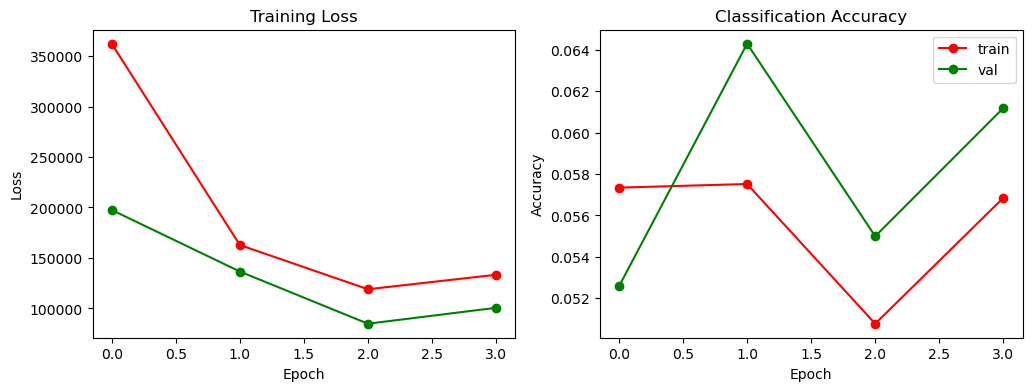

In [ ]:
#Training loss plot and accuracy plot

plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(loss_history_train, marker='o',color='r',label='train')
plt.plot(loss_history_val,marker='o',color='g',label='val')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1,2,2)
plt.plot(acc_history_train, marker='o',color='r',label='train')
plt.plot(acc_history_val,marker='o',color='g',label='val')
plt.title("Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
#Test loop

loss_history_test = []
acc_history_test = []

model.eval()
for epoch in range(1):
    total_loss = 0
    total_acc  = 0
    total_batches = 0

    with torch.no_grad():   
        for imgs, labels in test_loader:
            imgs   = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            preds = model(imgs)
            loss  = yolo_loss(preds, labels)
            acc   = yolo_accuracy(preds.detach(), labels)


            total_loss += loss.item()
            total_acc  += acc
            total_batches += 1

        avg_loss = total_loss / total_batches
        avg_acc  = total_acc  / total_batches

        loss_history_val.append(avg_loss)
        acc_history_val.append(avg_acc)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.3f}, Acc={avg_acc:.3f}")

In [ ]:
#Intersection over Union (IoU)

def iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x1a, y1a = x1 - w1/2, y1 - h1/2
    x1b, y1b = x1 + w1/2, y1 + h1/2

    x2a, y2a = x2 - w2/2, y2 - h2/2
    x2b, y2b = x2 + w2/2, y2 + h2/2

    xi1 = max(x1a, x2a)
    yi1 = max(y1a, y2a)
    xi2 = min(x1b, x2b)
    yi2 = min(y1b, y2b)

    inter = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    area1 = w1 * h1
    area2 = w2 * h2

    return inter / (area1 + area2 - inter + 1e-6)

In [ ]:
#Non-Maximum Suppression

def nms(boxes, scores, thresh=0.5):
    if len(boxes) == 0:
        return []
    idxs = scores.argsort(descending=True)
    keep = []
    while len(idxs) > 0:
        k = idxs[0].item()
        keep.append(k)
        new_idxs = []
        for i in idxs[1:]:
            i = i.item()
            if iou(boxes[k], boxes[i]) < thresh:
                new_idxs.append(i)
        idxs = torch.tensor(new_idxs, device=scores.device)
    return keep

In [ ]:
#Convert YOLO normalized boxes to image coordinates

def yolo_to_corners(box, W, H):
    x, y, w, h = box
    x *= W
    y *= H
    w *= W
    h *= H
    x0 = x - w/2
    y0 = y - h/2
    return x0, y0, w, h

In [ ]:
#Decode YOLO network output into bounding boxes

def get_predictions(pred, S=7, conf_thresh=0.6):
    pred = pred.detach().cpu()
    boxes, scores, classes = [], [], []

    for i in range(S):
        for j in range(S):
            cell = pred[i, j]

            obj = torch.sigmoid(cell[4]).item()
            if obj < conf_thresh:
                continue

            class_logits = cell[5:]
            cls = torch.argmax(class_logits).item()
            class_conf = torch.softmax(class_logits, dim=0)[cls].item()
            score = obj * class_conf

            px, py, pw, ph = cell[:4]
            x = (j + px) / S
            y = (i + py) / S
            w = pw**2
            h = ph**2

            # Convert to corners for NMS
            x1 = x - w / 2
            y1 = y - h / 2
            x2 = x + w / 2
            y2 = y + h / 2

            boxes.append([x1, y1, x2, y2])
            scores.append(score)
            classes.append(cls)

    if len(boxes) == 0:
        return [], [], []

    boxes = torch.tensor(boxes, dtype=torch.float32)
    scores = torch.tensor(scores)
    classes = torch.tensor(classes)

    keep = nms(boxes, scores, 0.2)

    return boxes[keep], classes[keep], scores[keep]


In [ ]:
#Extract ground-truth boxes

def get_ground_truth_boxes(target, S=7):
    obj_mask = target[...,4] == 1
    if obj_mask.sum() == 0:
        return [], []

    boxes = target[...,0:4][obj_mask]
    classes = target[...,5:].argmax(-1)[obj_mask]

    return boxes.cpu().tolist(), classes.cpu().tolist()

In [ ]:
#GT vs predictions visualization

def show_batch_detections(indices, cols=3, conf_thresh=0.3):
    rows = (len(indices) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img, target = train_ds_yolo[idx]
        inp = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(inp)[0]

        pred_boxes, pred_classes, pred_scores = get_predictions(pred, S=3, conf_thresh=conf_thresh)
        gt_boxes, gt_classes = get_ground_truth_boxes(target, S=3)

        W = img.shape[2]
        H = img.shape[1]
        img_show = img.permute(1,2,0).cpu().numpy()
        img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min() + 1e-6)
        ax.imshow(img_show)
        
        ax.set_title(f"Sample {idx}")
        ax.axis("off")

        for box, cls in zip(gt_boxes, gt_classes):
            x0, y0, w, h = yolo_to_corners(box, W, H)
            rect = patches.Rectangle((x0, y0), w, h, edgecolor="red", facecolor="none", linewidth=2)
            ax.add_patch(rect)
            ax.text(x0, y0-2, f"GT:{id_to_name[cls]}", color="red", fontsize=8, backgroundcolor="white")

        for box, cls, score in zip(pred_boxes, pred_classes, pred_scores):
            x0, y0, w, h = yolo_to_corners(box.tolist(), W, H)
            rect = patches.Rectangle((x0, y0), w, h, edgecolor="lime", facecolor="none", linewidth=2)
            ax.add_patch(rect)
            ax.text(x0, y0-2, f"{id_to_name[cls.item()]} {score:.2f}", color="lime", fontsize=8, backgroundcolor="black")

    for ax in axes[len(indices):]:
        ax.axis("off")

    plt.show()


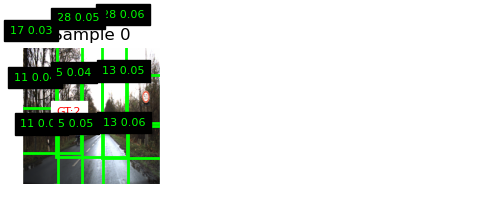

In [23]:
id_to_name = {i: str(i) for i in range(NUM_CLASSES)}
model.eval()
show_batch_detections([0], conf_thresh=0.2)

In [ ]:
#Video taken by ourself

video_path = r"C:\Users\Administrateur\Documents\3A\Computer vision\ICV project\ICV-project\IMG_1302.MOV"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Erreur: impossible d'ouvrir la vidéo")
    raise SystemExit

frame_id = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_id += 1

    # speedup: process 1 frame / 2
    if frame_id % 2 != 0:
        continue

    H0, W0 = frame.shape[:2]

    frame_resized = cv2.resize(frame, (448, 448))
    img = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img)[0]

    boxes, classes, scores = get_predictions(pred, S=7, conf_thresh=0.25, nms_thresh=0.5)

    for b, c, s in zip(boxes, classes, scores):
        x0, y0, w, h = yolo_to_corners(b, W0, H0)

        label = Classes[int(c.item())]
        text = f"{label} {s:.2f}"

        x0, y0, w, h = int(x0), int(y0), int(w), int(h)

        cv2.rectangle(frame, (x0, y0), (x0+w, y0+h), (0, 255, 0), 2)
        cv2.putText(frame, text, (x0, y0-8), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    cv2.imshow("YOLO Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()